In [2]:
# Importing datasets
import pandas as pd
import numpy as np
from fbprophet import Prophet


In [18]:
# Read train and test
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

# Convert to datetime format
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M')
train['hour'] = train.Datetime.dt.hour

In [19]:
train

,ID,Datetime,Count,hour
0,0,2012-08-25 00:00:00,8,0
1,1,2012-08-25 01:00:00,2,1
2,2,2012-08-25 02:00:00,6,2
3,3,2012-08-25 03:00:00,2,3
4,4,2012-08-25 04:00:00,2,4
...,...,...,...,...
18283,18283,2014-09-25 19:00:00,868,19
18284,18284,2014-09-25 20:00:00,732,20
18285,18285,2014-09-25 21:00:00,702,21
18286,18286,2014-09-25 22:00:00,580,22


In [20]:
# Calculate average hourly fraction
hourly_frac = train.groupby(['hour']).mean()/np.sum(train.groupby(['hour']).mean())
hourly_frac.drop(['ID'], axis = 1, inplace = True)
hourly_frac.columns = ['fraction']


# convert to time series from dataframe
train.index = train.Datetime
train.drop(['ID','hour','Datetime'], axis = 1, inplace = True)

daily_train = train.resample('D').sum()

In [21]:
daily_train

,Count
Datetime,
2012-08-25,76
2012-08-26,88
2012-08-27,62
2012-08-28,58
2012-08-29,60
...,...
2014-09-21,9102
2014-09-22,14116
2014-09-23,13304


In [23]:
daily_train['ds'] = daily_train.index
daily_train['y'] = daily_train.Count
daily_train.drop(['Count'],axis = 1, inplace = True)

AttributeError: 'DataFrame' object has no attribute 'Count'

In [24]:
daily_train

,ds,y
Datetime,,
2012-08-25,2012-08-25,76
2012-08-26,2012-08-26,88
2012-08-27,2012-08-27,62
2012-08-28,2012-08-28,58
2012-08-29,2012-08-29,60
...,...,...
2014-09-21,2014-09-21,9102
2014-09-22,2014-09-22,14116
2014-09-23,2014-09-23,13304


In [25]:
m = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1)
m.fit(daily_train)
future = m.make_future_dataframe(periods=213)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


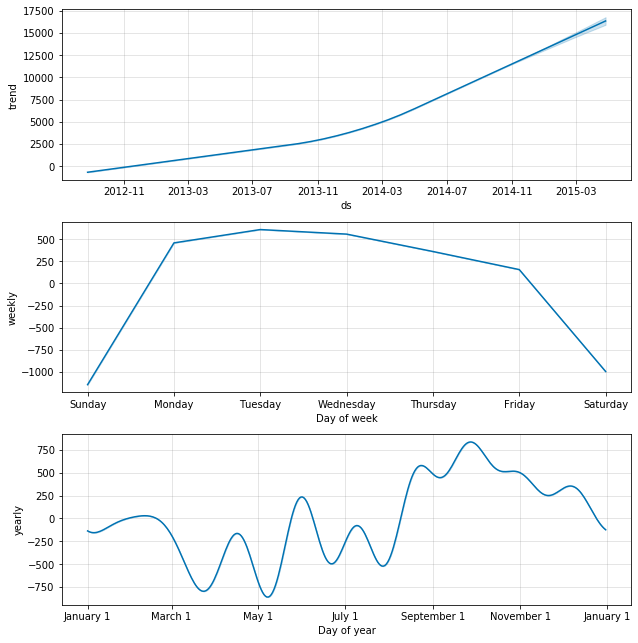

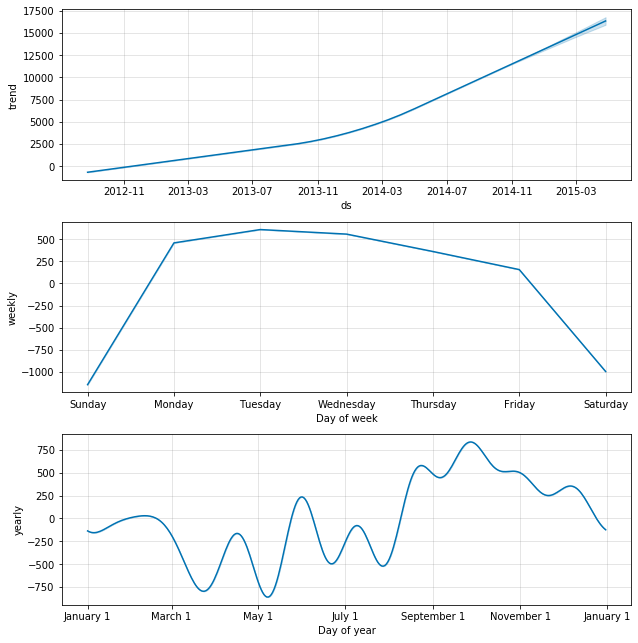

In [26]:
m.plot_components(forecast)

In [43]:
# Extract hour, day, month and year from both dataframes to merge

test['hour'] = test.Datetime.dt.hour
test['day'] = test.Datetime.dt.day
test['month'] = test.Datetime.dt.month
test['year'] = test.Datetime.dt.year



In [46]:
forecast['hour'] = forecast.ds.dt.hour
forecast['day'] = forecast.ds.dt.day
forecast['month'] = forecast.ds.dt.month
forecast['year'] = forecast.ds.dt.year

In [73]:
# Merge forecasts with given IDs
test = pd.merge(test,forecast, on=['day','month','year'], how='left')
cols = ['ID','hour','yhat']
test_new = test[cols]

# Merging hourly average fraction to the test data
test_new = pd.merge(test_new, hourly_frac, left_on = ['hour'], right_index=True, how = 'left')
# Convert daily aggregate to hourly traffic
test_new['Count'] = test_new['yhat'] * test_new['fraction']
test_new.drop(['yhat','fraction','hour'],axis = 1, inplace = True)
test_new.to_csv('prophet_sub.csv',index = False)

KeyError: "['yhat'] not in index"